# Mapping with Geopandas

Mapping is a GIS specialization unto itself, and no single reading can do justice to the many nuances of the field. But thanks to the modularity of Python and geopandas, even this short reading should equip you to create some relatively powerful static and even interactive plots. 


## Static Maps with matplotlib

As we saw in our previous readings, the `.plot()` command is an easy way to create maps in geopandas. Just calling `.plot()` results in geopandas visualizing our data in a relatively nice way:

<Axes: >

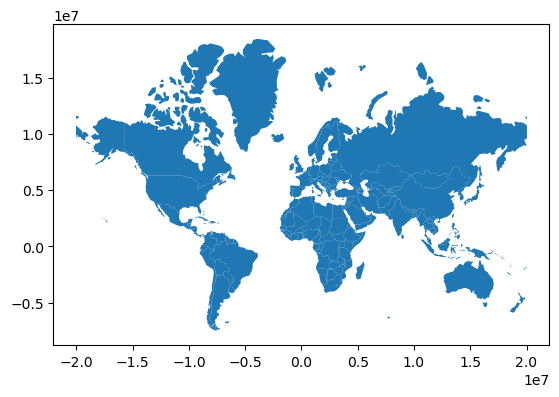

In [1]:
import geopandas as gpd
import re

world = gpd.read_file(
    "https://github.com/nickeubank/practicaldatascience_book/"
    "raw/refs/heads/main/notebooks/"
    "gis/example_data/world_countries/world_countries_mercator.geojson"
)

world.plot()

### Chloropleth Maps

Outlines are great, but if you pass `.plot()` a column name, geopandas will color locations on the map based on the value of that variable, creating a [choropleth map](https://en.wikipedia.org/wiki/Choropleth_map):

<Axes: title={'center': 'World GDP Per Capita'}>

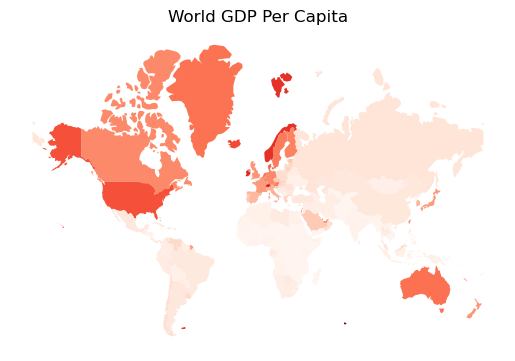

In [2]:
# For whatever reason, often geojson files load integers
# as int32, so it's good practice to cast to
# int64 before doing math to avoid integer overflow
# probems. I can't tell you the headaches I've experienced
# because numbers that should be really big
# ended up negative...
world["gdp_md"] = world["gdp_md"].astype("int64")
world["pop_est"] = world["pop_est"].astype("int64")


world["gdp_per_cap"] = (world["gdp_md"] * 1_000_000) / world["pop_est"]
world = world[world["name"] != "Antarctica"].copy()
ax = world.plot("gdp_per_cap", cmap="Reds")
ax.set_title("World GDP Per Capita")
ax.set_axis_off()
ax

### The Power of Using matplotlib

But the real power of this method of mapping is that geopandas is using matplotlib to create these figures. As a result, you can apply all the knowledge of matplotlib figures you have developed as a Python user (and which the LLMs have learned from the *huge* amount of training data that uses matplotlib) to help with your mapping.

<Axes: title={'center': 'The World'}>

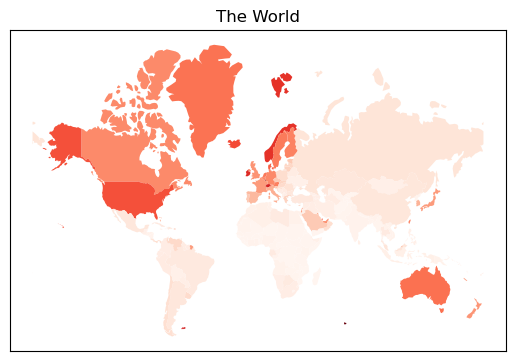

In [3]:
ax = world.plot("gdp_per_cap", cmap="Reds")
ax.set_title("The World")
ax.set_xticks([])
ax.set_yticks([])
ax

Indeed, for even more granular control, you can have geopandas plot directly onto a subplot with the `ax` keyword:

<Axes: title={'center': 'World GDP Per Capita'}>

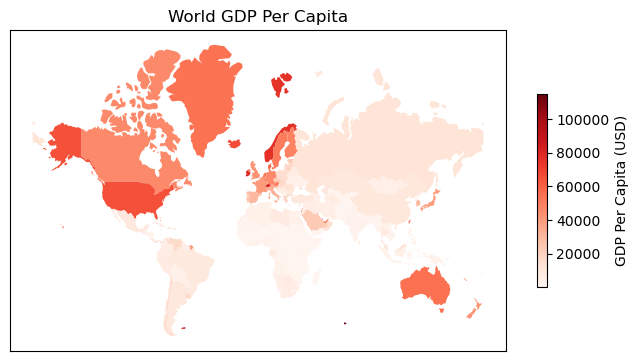

In [4]:
import matplotlib.pyplot as plt

# Create a subplot figure and axes object.
# Here I want one that's relatively wide
# to improve colorbar fit.
fig, ax = plt.subplots(figsize=(8, 5))

# use `ax=ax` to have geopandas plot onto the
# created axes
world.plot("gdp_per_cap", ax=ax, cmap="Reds")
ax.set_title("World GDP Per Capita")
ax.set_xticks([])
ax.set_yticks([])

# Now I can also work with colormaps in more detail
cbar = fig.colorbar(ax.collections[0], ax=ax, shrink=0.5)
cbar.set_label("GDP Per Capita (USD)")

ax

## Overlaying Data

This same trick can also be used to overlay different datasets. Below, I get data on cities and plot it onto the same `ax` object:

In [5]:
cities = gpd.read_file(
    "https://github.com/nickeubank/practicaldatascience_book/raw"
    "/refs/heads/main/notebooks/gis/example_data/world_cities/world_cities_mercator.geojson"
)

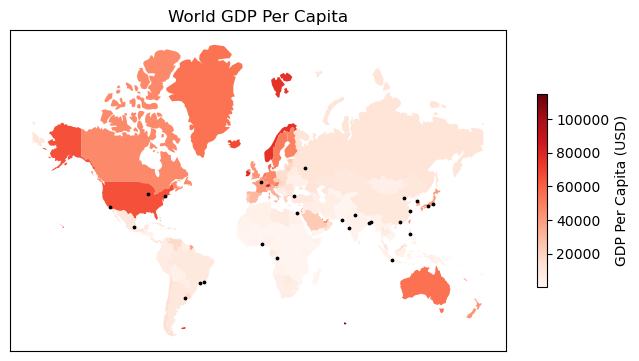

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))

world.plot("gdp_per_cap", ax=ax, cmap="Reds")
cities[cities.pop2020 > 9_000].plot(markersize=3, ax=ax, color="black", label="pop2020")
ax.set_title("World GDP Per Capita")
ax.set_xticks([])
ax.set_yticks([])

# Now I can also work with colormaps in more detail
cbar = fig.colorbar(ax.collections[0], ax=ax, shrink=0.5)
cbar.set_label("GDP Per Capita (USD)")

And yes, we can annotate these cities with their names if we want:

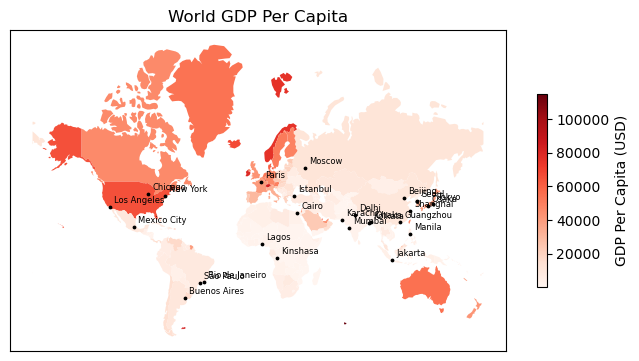

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

world.plot("gdp_per_cap", ax=ax, cmap="Reds")
cities[cities.pop2020 > 9_000].plot(markersize=3, ax=ax, color="black", label="pop2020")
ax.set_title("World GDP Per Capita")
ax.set_xticks([])
ax.set_yticks([])
cbar = fig.colorbar(ax.collections[0], ax=ax, shrink=0.5)
cbar.set_label("GDP Per Capita (USD)")

for idx, row in cities[cities.pop2020 > 9_000].iterrows():
    ax.annotate(
        row["name"],
        (row.geometry.x, row.geometry.y),  # x and y coordinates
        xytext=(3, 3),  # Distance from point
        textcoords="offset points",  # saying above is distance from point
        fontsize=6,
        ha="left",
        color="black",
    )

## Native Interactive Maps

Being able to make maps with `matplotlib` is great — it offers near infinite control of your figures through a familiar syntax (and one that LLMs know very well). 

But sometimes you want something more! Sometimes you want something interactive, and geopandas has you covered there too.

Geopandas comes bundled with [folium](https://python-visualization.github.io/folium/latest/getting_started.html), a simple library for creating interactive javascript-based maps, complete with basemaps. To create one, simply use the `.explore()` method:

In [8]:
world.explore()

### Folium Fragility

We haven't talked about projections or coordinate reference systems yet, so the warning I'm about to give won't make sense to most readers. However, because some people may come to this page trying to figure out their Folium issues, I want to put this warning here. I'll re-iterate it in our later reading on projections and Coordinate Reference Systems (CRS), so if this means nothing to you, just skip this sub-section.

Folium seems to be a little picky about Coordinate Reference Systems. If your data has been projected into a CRS it doesn't like, you may end up with a blank off-white map with no informative information systems:

![bad folium](images/bad_folium_map.png)

For example, when making this exercise I had originally projected these country outlines into a Robinson projection using `.to_crs("esri:54030")`. That was fine for geopandas, and it was find for mapping with matplotlib. But Folium? Nope — I had to pick a projection backed by an `epsg` code. Not only that, but I had to go back to the source data and re-project into the new epsg projection (I used web-mercator, `.to_crs(epsg=3857)`) — folium wasn't happy with my re-projecting the map in the `esri` projection into `epsg`. Why? No idea. 

### Folium Options

Which can also be combined with lots of options:

In [11]:
# world.explore(
#     column="pop_est",
#     scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
#     legend=False,  # show legend
#     k=10,  # use 10 bins
#     name="countries",  # name of the layer in the map
#     cmap="Reds",
# )

And of course you can also layer maps on top of one another:

In [12]:
cities = gpd.read_file(
    "https://github.com/nickeubank/practicaldatascience_book/raw"
    "/refs/heads/main/notebooks/gis/example_data/world_cities/world_cities_mercator.geojson"
)

In [13]:
# import folium

# # Assign map object to m
# m = world.explore(
#     column="pop_est",
#     scheme="naturalbreaks",
#     legend=False,
#     k=10,
#     name="countries",
#     cmap="Reds",
# )

# cities.explore(
#     m=m,  # pass map you want to add to here.
#     color="red",  # use red color on all points
#     marker_kwds=dict(radius=5, fill=True),  # make marker radius 10px with fill
#     tooltip="pop_max",  # show "name" column in the tooltip
#     tooltip_kwds=dict(labels=False),  # do not show column label in the tooltip
#     name="Cities",  # name of the layer in the map
# )

To learn more, [you can read the full docs here!](https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html) and/or try it yourself!